# Import Libraries

In [47]:
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate

# Summary


# 1 - Load Data

The First Step of this project was to import the data into the dataframes

In [2]:
#https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Books.csv

data = pd.read_csv('Ratings.csv')

book = pd.read_csv('Books.csv',low_memory=False)



b_data = pd.merge(data,
                 book[['ISBN', 'Book-Title','Book-Author','Publisher']],
                 on='ISBN', 
               how='inner')

print(data.shape)
print(b_data.shape)

b_data=b_data[b_data['Book-Rating']>0].reset_index()

print(b_data.shape)




(1149780, 3)
(1031136, 6)
(383842, 7)


When loading the dataset we verify if the we had information about the bookings that had reviews based on the ISBN. By doing this we have performed an inner join between the dataframe data anda book. With the function shape it is possible to observe that more than we were not able to find the charectistics of the books from 100k reviews.

Also, we have considered that it was only possible to review a book from 1 to 10 so, we have limited the dataframe to reviews with score greater than 0, with this step we reduce our data to be analysed and predicted.

In [3]:
count_u=0
count_i=0
di_u={}
di_i={}


for i in range(len(b_data)):
    if b_data.loc[i,'User-ID'] in di_u:
        b_data.loc[i,'User-ID'] = di_u[b_data.loc[i,'User-ID']]
    else:
        di_u[b_data.loc[i,'User-ID']]=count_u
        b_data.loc[i,'User-ID'] = di_u[b_data.loc[i,'User-ID']]
        count_u += 1
        
    if b_data.loc[i,'ISBN'] in di_i:
        b_data.loc[i,'ISBN'] = di_i[b_data.loc[i,'ISBN']]
    else:
        di_i[b_data.loc[i,'ISBN']] = count_i
        b_data.loc[i,'ISBN']=di_i[b_data.loc[i,'ISBN']]
        count_i += 1

The code above represents the indexation of users and books in a sequencial order to allow better analysis in this project

# 2 -  Exploratory Data Analysis

We start this step by analysing the missing values, quality of the data and distribution of the results

In [4]:
b_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383842 entries, 0 to 383841
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   index        383842 non-null  int64 
 1   User-ID      383842 non-null  int64 
 2   ISBN         383842 non-null  object
 3   Book-Rating  383842 non-null  int64 
 4   Book-Title   383842 non-null  object
 5   Book-Author  383841 non-null  object
 6   Publisher    383840 non-null  object
dtypes: int64(3), object(4)
memory usage: 20.5+ MB


We only have 2 rows with the Publisher missing and 1 where the Author is missing

In [5]:
b_data[b_data['Book-Author'].isnull()]

,index,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
324298,863398,7428,97100,8,The Credit Suisse Guide to Managing Your Perso...,NaN,Edinburgh Financial Publishing


In [6]:
b_data[b_data['ISBN']==97100]

,index,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
324298,863398,7428,97100,8,The Credit Suisse Guide to Managing Your Perso...,NaN,Edinburgh Financial Publishing


Since there was only one entry on the data set the only way to fill the Author name was by searching the book online. 

In [7]:
b_data.loc[b_data['ISBN']==97100,'Book-Author'] = 'Larissa Anne Downes'

In [8]:
b_data.loc[b_data['ISBN']==97100,'Book-Author']

324298    Larissa Anne Downes
Name: Book-Author, dtype: object

In [9]:
b_data[b_data['Publisher'].isnull()]

,index,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
324148,862973,7,96985,9,Tyrant Moon,Elaine Corvidae,NaN
324158,862984,7,96994,9,Finders Keepers,Linnea Sinclair,NaN


In [10]:
b_data[b_data['ISBN']==96985] 

,index,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
324148,862973,7,96985,9,Tyrant Moon,Elaine Corvidae,NaN


In [11]:
b_data.loc[b_data['ISBN']==96985,'Publisher'] ='Mundania Press'

In [12]:
b_data[b_data['ISBN']==96994] 

,index,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher
324158,862984,7,96994,9,Finders Keepers,Linnea Sinclair,NaN


In [13]:
b_data.loc[b_data['ISBN']==96994,'Publisher']='Bantam'

Once again there was only one entry in the dataset so we have searched online for the publishers

In [14]:
b_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383842 entries, 0 to 383841
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   index        383842 non-null  int64 
 1   User-ID      383842 non-null  int64 
 2   ISBN         383842 non-null  object
 3   Book-Rating  383842 non-null  int64 
 4   Book-Title   383842 non-null  object
 5   Book-Author  383842 non-null  object
 6   Publisher    383842 non-null  object
dtypes: int64(3), object(4)
memory usage: 20.5+ MB


## 2.1 - Book Rating

In order to understand the behavior of the reviews we got, the first step was to analyse the distribution of the reviews we had

In [15]:
np.sort(b_data['Book-Rating'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

Text(0.5, 1.0, 'Number of Reviews per Rating')

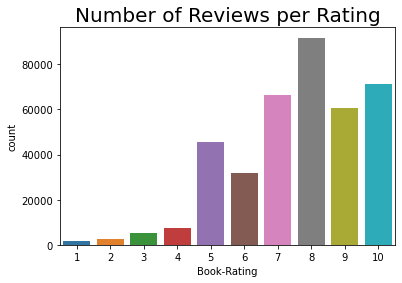

In [16]:
sns.countplot(data=b_data, x='Book-Rating')
plt.title('Number of Reviews per Rating',fontsize=20)

By plotting the number of reviews for each rating we can observe that the most common review value is 8 and the majority of the reviewers give a rating of 5 or higher to the books.
With this conclusion it will be interesting to understanding if the recommendation system accuracy improves if we only consider reviews of 5 or higher

## 2.2 - Book Analysis

The next step was to understand the number of different books we have and if they all have the same number (or similiar number) of reviews

In [17]:
np.set_printoptions(threshold=sys.maxsize)
b_data['ISBN'].nunique()

149836

Text(0.5, 1.0, 'Reviews Per Book')

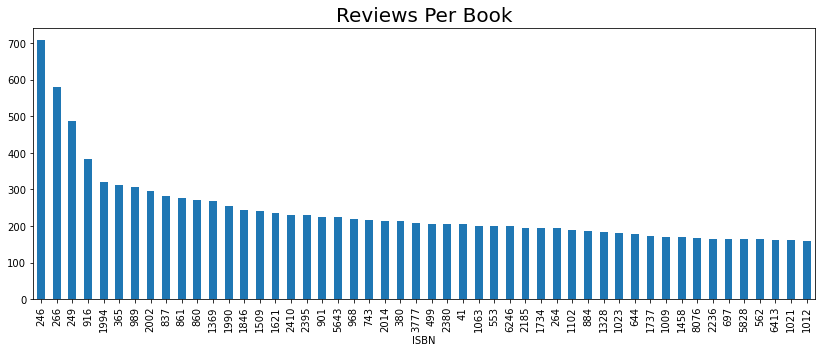

In [18]:
b_data.groupby(['ISBN'])['Book-Rating'].count().sort_values(ascending=False)[:50].plot(kind='bar',figsize=(14,5))
plt.title('Reviews Per Book',fontsize=20)

In [19]:
b_data.groupby(['ISBN'])['Book-Rating'].count().sort_values(ascending=False).describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

count    149836.000000
mean          2.561748
std           7.505562
min           1.000000
10%           1.000000
20%           1.000000
30%           1.000000
40%           1.000000
50%           1.000000
60%           1.000000
70%           2.000000
80%           2.000000
90%           4.000000
max         707.000000
Name: Book-Rating, dtype: float64

In [20]:
df = pd.DataFrame(b_data.groupby(['ISBN','Book-Title'])['Book-Rating'].count().sort_values(ascending=False),index=None)
df2 = df[df['Book-Rating']>4].reset_index()
df2.shape
df2.head()

,ISBN,Book-Title,Book-Rating
0,246,The Lovely Bones: A Novel,707
1,266,Wild Animus,581
2,249,The Da Vinci Code,487
3,916,The Red Tent (Bestselling Backlist),383
4,1994,Divine Secrets of the Ya-Ya Sisterhood: A Novel,320


In [21]:
pd.DataFrame(b_data.groupby(['ISBN','Book-Title'])['Book-Rating'].agg([np.count_nonzero, np.mean])).describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,count_nonzero,mean
count,149836.000000,149836.000000
mean,2.561748,7.527543
std,7.505562,1.711876
min,1.000000,1.000000
10%,1.000000,5.000000
20%,1.000000,6.000000
30%,1.000000,7.000000
40%,1.000000,7.000000
50%,1.000000,8.000000
60%,1.000000,8.000000


With this analysis, it was possible to observe that there are books that have a very high number of reviews and the next rating ones decrease in a linear way.
Also, since 90% of the books have 4 or less reviews, to improve the accuracy of the recommendation system we can use only books that were reviewed more than 4 times.

## 2.3 - Book Author

The final Analysis was in regards of the book authors. Here we want to understand if the number of reviews a author has, impacts the average score 

In [22]:
b_data['Book-Author'].nunique()

62114

In [23]:
ba_data=pd.DataFrame(b_data.groupby(['Book-Author'])['Book-Rating'].agg([np.count_nonzero, np.mean]))

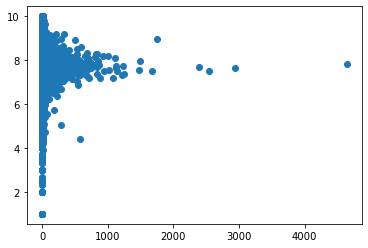

In [24]:
plt.scatter(ba_data['count_nonzero'], ba_data['mean'])
plt.show()

In [25]:
ba_data.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,count_nonzero,mean
count,62114.000000,62114.000000
mean,6.179637,7.514813
std,42.811930,1.670584
min,1.000000,1.000000
10%,1.000000,5.000000
20%,1.000000,6.000000
30%,1.000000,7.000000
40%,1.000000,7.000000
50%,1.000000,7.750000
60%,2.000000,8.000000


In [26]:
ba_data2 = ba_data[ba_data['count_nonzero']>=8]
aut = np.array(ba_data2.index)

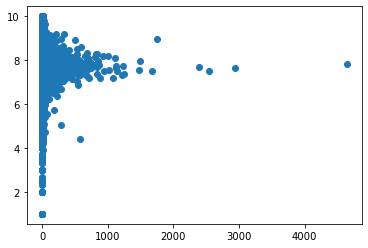

In [27]:
plt.scatter(ba_data['count_nonzero'], ba_data['mean'])
plt.show()

With this scatter plot we can see that the increase amount of reviews for a Author results in the average review per author to be around 8.
Since 90% of the authors have 8 or less reviews to increase the recommendation model we can try to select only authors with more than 8 reviews

# 3 - Recommendation System 

To apply a recommendation system for the combination User x Item, we will use the package Surprise and three different methodologies in order to understand which one is the best for the currernt project. These methodologies are:
1. Normal Predictor
2. KNN Basic
3. SVD

## 3.1 - Using the main dataset without filtering

In [48]:
#Rating Scale from 1-10
reader = Reader(rating_scale=(1, 10))
#Have the right order of the columns
data = Dataset.load_from_df(b_data[["User-ID", "ISBN", "Book-Rating"]], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
print('Normal Predictor:',cross_validate(NormalPredictor(), data, cv=5))
print('KNN Basic:',cross_validate(KNNBasic(), data, cv=5))
print('SVD:',cross_validate(SVD(), data, cv=5))

Normal Predictor: {'test_rmse': array([2.50432791, 2.4932666 , 2.50692213, 2.51184451, 2.50439648]), 'test_mae': array([1.99909138, 1.99021294, 2.00101988, 2.00334293, 1.99841217]), 'fit_time': (0.4015927314758301, 0.5116405487060547, 0.5538828372955322, 0.5390088558197021, 0.5227370262145996), 'test_time': (0.3995859622955322, 0.5483787059783936, 0.5771021842956543, 0.6665480136871338, 0.6516165733337402)}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNN Basic: {'test_rmse': array([1.93237584, 1.94344664, 1.93433971, 1.93067784, 1.95129194]), 'test_mae': array([1.52179495, 1.5312376 , 1.52197976, 1.52047686, 1.53286796]), 'fit_time': (30.61154866218567, 30.10428595542907

For this problem the best method to be used for the recommendation system was the SVD since it was the one with the lowest root mean square deviation (1.64) and mean average error (1.26) followed by the KNN Basic and with the worst result by far the Normal Predictor

## 3.2 - Filtering Books w/ review >= than 5

Following the first idea we had during our analysis (Filtering the data set for the entries with reviews equal or greater than 5) we have created a new dataset and will apply the same recommendation system methods

In [49]:
rate_data = b_data[b_data['Book-Rating']>=5]

In [50]:
#Have the right order of the columns

data = Dataset.load_from_df(rate_data[["User-ID", "ISBN", "Book-Rating"]], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
print('Normal Predictor:',cross_validate(NormalPredictor(), data, cv=5))
print('KNN Basic:',cross_validate(KNNBasic(), data, cv=5))
print('SVD:',cross_validate(SVD(), data, cv=5))

Normal Predictor: {'test_rmse': array([2.17683505, 2.16643321, 2.17210107, 2.17811641, 2.17498302]), 'test_mae': array([1.75852439, 1.75024584, 1.7542994 , 1.76080623, 1.75270825]), 'fit_time': (0.4157545566558838, 0.4964165687561035, 0.5307180881500244, 0.5775258541107178, 0.5066766738891602), 'test_time': (0.5679116249084473, 0.4093606472015381, 0.4482607841491699, 0.5929970741271973, 0.6542081832885742)}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNN Basic: {'test_rmse': array([1.67444312, 1.67784666, 1.67695044, 1.6777957 , 1.68761049]), 'test_mae': array([1.34246114, 1.34782258, 1.34814505, 1.34714476, 1.35728915]), 'fit_time': (25.84939479827881, 28.19416189193725

The statistical measures to test the accuracy of the model have shown that here, again the SVD was the best method and has predict the quality of the predictions was improved significantly, the remaining methods have increased in the same way as the SVD, maintaining the same quality order

## 3.3 - Filtering Books w/ more than 4 reviews

The second idea we had during our analysis (Considering only books with more than 4 reviews) we have created a new dataset and will apply the same recommendation system methods

In [51]:
rev_data = b_data[b_data['Book-Title'].isin(df2['Book-Title'])]

In [52]:
#Have the right order of the columns

data = Dataset.load_from_df(rev_data[["User-ID", "ISBN", "Book-Rating"]], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
print('Normal Predictor:',cross_validate(NormalPredictor(), data, cv=5))
print('KNN Basic:',cross_validate(KNNBasic(), data, cv=5))
print('SVD:',cross_validate(SVD(), data, cv=5))

Normal Predictor: {'test_rmse': array([2.43279408, 2.42551676, 2.42972375, 2.4200042 , 2.41923472]), 'test_mae': array([1.93319641, 1.93104677, 1.93029687, 1.92423526, 1.92222553]), 'fit_time': (0.18217062950134277, 0.258319616317749, 0.23431825637817383, 0.23431730270385742, 0.2343158721923828), 'test_time': (0.28118395805358887, 0.19099879264831543, 0.18745875358581543, 0.17183446884155273, 0.2655625343322754)}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNN Basic: {'test_rmse': array([1.91986615, 1.8981108 , 1.91324137, 1.90729098, 1.90923665]), 'test_mae': array([1.47595249, 1.45270355, 1.46925809, 1.46593668, 1.46773617]), 'fit_time': (14.359928846359253, 15.0750105

This approach, when comparing with the base test it got better statistical results, but when comparing with the first experiment based on the data analysis, the results were worse. Nevertheless the quality order of the methods was the same, the best method was the SVD

## 3.4 - Filtering Authors w/  8 or more reviews

The third idea we had during our analysis (Considering only authors with 8 or more reviews) we have created a new dataset and will apply the same recommendation system methods

In [53]:
aut_data = b_data[b_data['Book-Author'].isin(aut)]

In [54]:
#Have the right order of the columns

data = Dataset.load_from_df(aut_data[["User-ID", "ISBN", "Book-Rating"]], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
print('Normal Predictor:',cross_validate(NormalPredictor(), data, cv=5))
print('KNN Basic:',cross_validate(KNNBasic(), data, cv=5))
print('SVD:',cross_validate(SVD(), data, cv=5))

Normal Predictor: {'test_rmse': array([2.46833244, 2.45481446, 2.45185895, 2.46090694, 2.45767154]), 'test_mae': array([1.97033243, 1.95312143, 1.95210025, 1.96193431, 1.95729173]), 'fit_time': (0.2916104793548584, 0.3515629768371582, 0.3592865467071533, 0.34366536140441895, 0.38530516624450684), 'test_time': (0.45569276809692383, 0.30009937286376953, 0.26556396484375, 0.3905313014984131, 0.2661011219024658)}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNN Basic: {'test_rmse': array([1.92712358, 1.93295188, 1.93776343, 1.91740627, 1.93272095]), 'test_mae': array([1.50127996, 1.50579625, 1.50640737, 1.49291242, 1.50473793]), 'fit_time': (20.43819499015808, 22.316972970962

On This Data Set when comparing with the standard dataset the Normal Predictor got worse results but the other two showed improvements.
When comparing with the other two datasets with changes, it was the one with the worse results

## 3.5 Combine all the previous filters that improve in the 2 methods

Our final Idea was to combine the dataset used on 3.2 and 3.3 in order to increase the accuracy of the models

In [55]:
pre_final = rate_data[rate_data['Book-Title'].isin(df2['Book-Title'])]

In [56]:
#final = pre_final[pre_final['Book-Author'].isin(aut)]

In [57]:
#Have the right order of the columns

data = Dataset.load_from_df(pre_final[["User-ID", "ISBN", "Book-Rating"]], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
print('Normal Predictor:',cross_validate(NormalPredictor(), data, cv=5))
print('KNN Basic:',cross_validate(KNNBasic(), data, cv=5))
print('SVD:',cross_validate(SVD(), data, cv=5))

Normal Predictor: {'test_rmse': array([2.10404454, 2.10825302, 2.09693486, 2.10704183, 2.08784413]), 'test_mae': array([1.70154416, 1.69834799, 1.68934996, 1.69947046, 1.68145481]), 'fit_time': (0.1874547004699707, 0.2590160369873047, 0.27309727668762207, 0.2638132572174072, 0.2413327693939209), 'test_time': (0.29680967330932617, 0.19186687469482422, 0.19187283515930176, 0.19814181327819824, 0.20812702178955078)}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
KNN Basic: {'test_rmse': array([1.63421538, 1.65338877, 1.64692076, 1.64504999, 1.65544695]), 'test_mae': array([1.28347724, 1.30124713, 1.29175246, 1.29244718, 1.30003216]), 'fit_time': (14.78264045715332, 17.55577707

The combination of Reviews greater than 5 and books with at least 5 reviews, gave the best result in terms of accuracy.
Once again the SVD method was the best one.

# 4 - Conclusions

During this project it was important to understand that there are no perfect datasets in the world so the first step is always to understand the data and try to clean it as best as possible.
After this we tried to understand if all entries were necessary or if the majority of data is concentrated with certain characteristics.

We have concluded that the most common rating for the books was 8 and that the majority of reviews had a rate equal or greater than 5. Also, looking to the books we have notice that only 10% of the books have more than 4 reviews. And the final conclusion was regarding the authors were we could see that the increase of reviews makes the rating average of each author to be closer to 8, and 10% of the authors have 8 or more reviews.

In the Recommendation system we started by applying three methods (Normal Predictor, KNN Basic and SVD) to the full data set. With this we conclude that the best method was the SVD, followed by the KNN Basic and Normal predictor (to determine the best method we used two statistical methodologies RMSE and MAE). The next step was to consider the insights extracted from our exploratory data analysis and the best combination was when we filtered our data to books with at least 5 reviews and reviews with a rating of at least five. Through all our testing the best method and worse was always the same. So we can conclude that SVD was the best methodology for this project and that our insights from the exploratory data analysis were important in increasing the accuracy of the recommendation system.
